In [67]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2023-05-19 00:50:40.103833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 00:50:40.694035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Usando dados de [Hirokazu Takaya](https://lisphilar.github.io/covid19-sir/). Separando aqui para citação correta posteriormente.

In [3]:
# Importando dados
import covsirphy as cs

/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(366, 3)


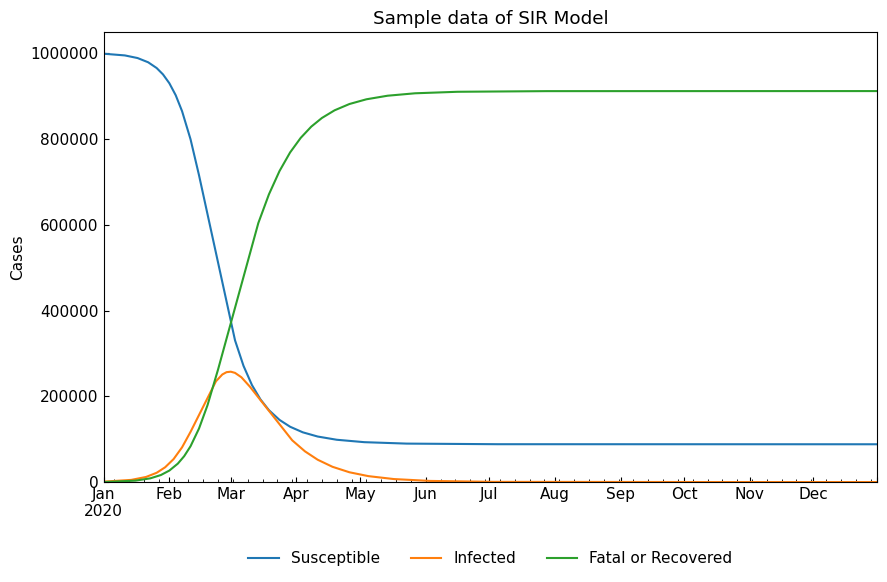

In [45]:
sir = cs.SIRModel.from_sample(date_range=("01Jan2020", "31Dec2020"), tau=1440)
sir_df = sir.solve()
print(sir_df.shape)
cs.line_plot(sir_df, title=f"Sample data of {sir}", y_integer=True)

In [54]:
eng = cs.DataEngineer()
eng.download(databases=["covid19dh", "owid"])
eng.clean()
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272562 entries, 0 to 272561
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 272562 non-null  category      
 1   Province                             272562 non-null  category      
 2   City                                 272562 non-null  category      
 3   Date                                 272562 non-null  datetime64[ns]
 4   Cancel_events                        272562 non-null  Float64       
 5   Confirmed                            272562 non-null  Float64       
 6   Contact_tracing                      272562 non-null  Float64       
 7   Country                              272562 non-null  object        
 8   Fatal                                272562 non-null  Float64       
 9   Gatherings_restrictions              272562 non-null  Float64       
 

In [77]:
main_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
eng.transform()
eng_all = eng.all(variables=main_variables)

In [78]:
print(eng_all.shape)
eng_all

(272562, 8)


,ISO3,Province,City,Date,Susceptible,Infected,Recovered,Fatal
0,ABW,-,-,2020-01-22,105845.0,0.0,0.0,0.0
1,ABW,-,-,2020-01-23,105845.0,0.0,0.0,0.0
2,ABW,-,-,2020-01-24,105845.0,0.0,0.0,0.0
3,ABW,-,-,2020-01-25,105845.0,0.0,0.0,0.0
4,ABW,-,-,2020-01-26,105845.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
272557,ZWE,-,-,2023-03-05,14174891.0,175465.0,82994.0,5668.0
272558,ZWE,-,-,2023-03-06,14174891.0,175465.0,82994.0,5668.0
272559,ZWE,-,-,2023-03-07,14174891.0,175465.0,82994.0,5668.0
272560,ZWE,-,-,2023-03-08,14174742.0,175611.0,82994.0,5671.0


In [79]:
eng_all['ISO3'].unique()

['ABW', 'AFG', 'AGO', 'AIA', 'ALB', ..., 'WSM', 'YEM', 'ZAF', 'ZMB', 'ZWE']
Length: 235
Categories (235, string): [ABW, AFG, AGO, AIA, ..., YEM, ZAF, ZMB, ZWE]

In [80]:
# check how many eng['ISO3'] == 'JPN'
eng_all[eng_all['ISO3'] == 'JPN']

,ISO3,Province,City,Date,Susceptible,Infected,Recovered,Fatal
123146,JPN,-,-,2020-02-05,0.0,0.0,0.0,0.0
123147,JPN,-,-,2020-02-06,126529084.0,12.0,4.0,0.0
123148,JPN,-,-,2020-02-07,126529084.0,12.0,4.0,0.0
123149,JPN,-,-,2020-02-08,126529084.0,12.0,4.0,0.0
123150,JPN,-,-,2020-02-09,126529084.0,12.0,4.0,0.0
...,...,...,...,...,...,...,...,...
124330,JPN,-,-,2023-05-04,92762143.0,13392365.0,20299978.0,74614.0
124331,JPN,-,-,2023-05-05,92756336.0,13398153.0,20299978.0,74633.0
124332,JPN,-,-,2023-05-06,92750107.0,13404370.0,20299978.0,74645.0
124333,JPN,-,-,2023-05-07,92735671.0,13418797.0,20299978.0,74654.0


In [81]:
data = eng_all[eng_all['ISO3'] == 'JPN'][['Date', 'Susceptible', 'Infected', 'Recovered', 'Fatal']]
data.head()

,Date,Susceptible,Infected,Recovered,Fatal
123146,2020-02-05,0.0,0.0,0.0,0.0
123147,2020-02-06,126529084.0,12.0,4.0,0.0
123148,2020-02-07,126529084.0,12.0,4.0,0.0
123149,2020-02-08,126529084.0,12.0,4.0,0.0
123150,2020-02-09,126529084.0,12.0,4.0,0.0


In [82]:
# checando se data está crescente
data['Date'].is_monotonic_increasing

True

In [76]:
# solve SIR model
sir = cs.SIRModel.from_data(data, tau=1440)

TypeError: from_data() missing 1 required positional argument: 'param_dict'

SIR sem fator de normalização.
$$\ \dot{S} = - \beta I S$$
$$\ \dot{I} = \beta I S - \gamma I$$
$$\ \dot{R} = - \gamma I S$$

In [5]:
# Criando 1000 pontos, com pouca variação entre si
dt = 0.01; T = 9.99; t = np.arange(0,T+dt,dt)
print(t.shape)
t

(1000,)


array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.